In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from IPython.display import clear_output
from time import sleep
from pylab import rcParams

%matplotlib inline
%load_ext autoreload
%autoreload 2

rcParams['figure.figsize'] = 10, 20

In [2]:
from model.linear_observer_planter import LinearPlanterObserver
from env.env_naive_torus import NaiveSandbox
from loss.losses import sum_loss_l1
from model.a2c import *
from reward.rewards import AliveCellsReward

In [3]:
def probs_to_cells(probs, env, topk=3):
    probs_top_k, idx_top_k = probs.topk(topk)
    inserted_block = np.zeros(env.shape)
    inserted_block = inserted_block.flatten()
    inserted_block[idx_top_k] = 1
    return inserted_block.reshape(env.shape)

In [41]:
# total_loss = agent.reflect(np.random.rand(10, 1000),list(range(10)), list(range(10)), list(range(10)))

In [42]:
# optimizer.zero_grad()
# total_loss.backward()
# nn.utils.clip_grad_norm_(agent.parameters(), 0.5)
# optimizer.step()

In [45]:
list_loss = []
# dummy reward_f
from reward.rewards import AliveCellsReward
reward_f = AliveCellsReward()

In [46]:
iterations = 10
steps_after_action = 10

In [68]:
def render(perception_field, env_state, render_agent=True):
    clear_output(wait=True)
    if render_agent:
        plt.imshow(perception_field)
        plt.show()
    #print('field after agent inference')
    plt.imshow(env_state['grid'])
    plt.show()

In [107]:
GRID = 10

In [113]:
agent = ActorCritic(GRID*GRID, GRID*GRID)

In [114]:
optimizer = optim.Adam(agent.parameters(), lr=LR)

In [115]:
grid_size=(GRID,GRID)
agent_window_size = 10 
sandbox = NaiveSandbox(grid_size=grid_size)

In [116]:
x0, y0 = 0, 0
iterations = 50
steps_after_action = 20
N_GAMES = 150
N_CELLS = 5
state = sandbox.get_grid()
from time import sleep
list_loss = []
for game in range(N_GAMES):
    states, actions, rewards, dones = [], [], [], []
    for i in range(iterations):
        probs = agent.get_action_probs(torch.tensor(sandbox.get_grid()).float().flatten())
        perception_field = probs_to_cells(probs.detach(), sandbox.get_grid(), N_CELLS)
        env_state = sandbox.forward(inserted_block=perception_field, 
                                    inserted_block_position_x0=x0, 
                                    inserted_block_position_y0=y0, 
                                    n_steps=steps_after_action,
                                    reward_fn=reward_f 
                                   )
        next_state, reward, done = env_state['grid'], env_state['reward'], env_state['done']
        states.append(state.flatten()); actions.append(perception_field); rewards.append(reward); dones.append(done)
        
        state = next_state
        #render(perception_field, env_state, render_agent=True)
    total_loss = agent.reflect(states, actions, rewards, dones)
    optimizer.zero_grad()
    total_loss.backward()
    if np.isnan(total_loss.item()):
        break
    list_loss.append(total_loss.item())
    clear_output(wait=True)
    plt.plot(list(range(len(list_loss))), list_loss)
    plt.show()
    nn.utils.clip_grad_norm_(agent.parameters(), 0.5)
    optimizer.step()

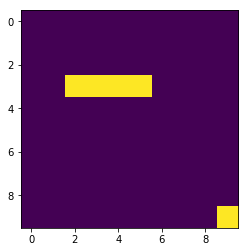

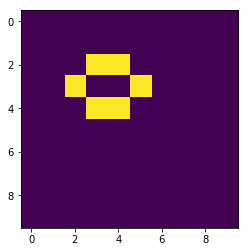

In [118]:
state = sandbox.get_grid()
from time import sleep
#list_loss = []
states, actions, rewards, dones = [], [], [], []
for i in range(10):
    probs = agent.get_action_probs(torch.tensor(sandbox.get_grid()).float().flatten())
    perception_field = probs_to_cells(probs.detach(), sandbox.get_grid(), N_CELLS)
    env_state = sandbox.forward(inserted_block=perception_field, 
                                inserted_block_position_x0=x0, 
                                inserted_block_position_y0=y0, 
                                n_steps=steps_after_action,
                                reward_fn=reward_f 
                               )
    next_state, reward, done = env_state['grid'], env_state['reward'], env_state['done']
    states.append(state.flatten()); actions.append(perception_field); rewards.append(reward); dones.append(done)

    state = next_state
    render(perception_field, env_state, render_agent=True)